In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
df = pd.read_csv(r"D:\Final_Year_Project\NHANES_11_14_survPA_Python.csv")
df.head()

,SEQN,Age,Race,BMI,sex,Mobility,mortstat,diabetes.y,poverty_level,Asthma,...,time_mort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,62174,80,3,33.9,0,2,1,0,4.28,0,...,1.750000,-2.486584,-0.846437,-0.006031,-0.259103,-0.635918,-0.162398,0.020143,0.616825,0.003952
1,62178,80,3,28.5,0,2,1,0,1.10,0,...,0.583333,-2.276258,1.392933,-0.185974,-0.976587,0.357515,-0.090258,-0.172509,-0.757191,0.149032
2,62209,62,1,26.0,1,2,0,0,1.38,0,...,7.333333,2.468527,-0.793733,0.000834,-1.000091,-0.092452,-0.979914,-0.258313,-0.177137,-0.171682
3,62215,65,3,26.7,1,2,0,1,0.00,0,...,7.833333,4.087644,-1.134610,-1.249760,0.778763,0.528401,-0.575059,-0.892245,-0.291914,0.988347
4,62217,77,1,30.6,1,1,1,1,0.97,0,...,6.583333,2.673649,1.616638,-0.167374,-0.373244,0.316038,-0.452131,-0.286315,-0.319348,-0.166834


In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [4]:
# Step 2: Shuffle the dataset to ensure randomness
df1 = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split into train (64%), validation (16%), and test (20%)

# Test Set (20% of total data)
df_test = df1.sample(frac=0.2, random_state=42)
df_train = df1.drop(df_test.index)

# Validation Set (20% of remaining data, i.e., 16% of total data)
df_val = df_train.sample(frac=0.2, random_state=42)
df_train = df_train.drop(df_val.index)

In [5]:
cols_standardize = ['Age', 'Race', 'BMI', 'poverty_level', 'PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']
cols_leave = ['Race', 'sex', 'Mobility', 'diabetes.y', 'Asthma', 'Arthritis', 'heart_failure', 'coronary_heart_disease', 
              'angina', 'stroke', 'thyroid', 'bronchitis', 'cancer']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors and move to CUDA if available
x_train = torch.tensor(x_mapper.fit_transform(df_train).astype('float32')).to(device)
x_test = torch.tensor(x_mapper.transform(df_test).astype('float32')).to(device)

get_target = lambda df: (torch.tensor(df['time_mort'].values, dtype=torch.float32).to(device),
                         torch.tensor(df['mortstat'].values, dtype=torch.float32).to(device))

y_train = get_target(df_train)
y_test = get_target(df_test)
durations_test, events_test = get_target(df_test)
val = x_test, y_test

In [7]:
durations_np = durations_test.cpu().numpy()
events_np = events_test.cpu().numpy()
print(type(durations_np), type(events_np))  # Should print <class 'numpy.ndarray'> <class 'numpy.ndarray'>

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
in_features = x_train.shape[1]
num_nodes = [256, 256]
out_features = 1
batch_norm = True
dropout = 0.7
output_bias = False

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
net_tuned = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias).to(device)

In [9]:
model_tuned = CoxPH(net_tuned, tt.optim.Adam)

C:\Users\gh22s\AppData\Local\Programs\Python\Python310\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torc

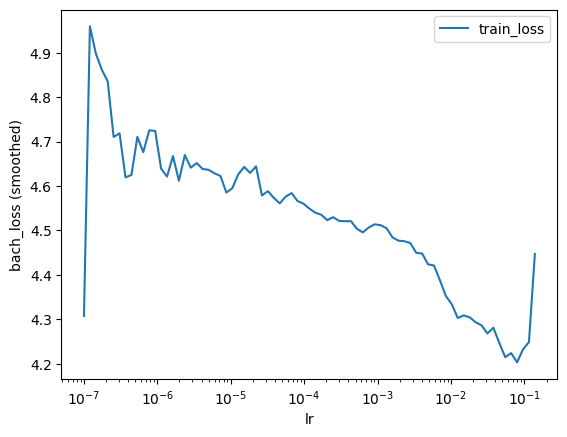

In [10]:
batch_size = 64
lrfinder_tuned = model_tuned.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder_tuned.plot()

In [11]:
best_lr = lrfinder_tuned.get_best_lr()

In [12]:
model_tuned.optimizer.set_lr(best_lr)

In [13]:
epochs = 1516
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [14]:
%%time
log = model_tuned.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.1613,	val_loss: 3.4966
1:	[0s / 0s],		train_loss: 3.7952,	val_loss: 3.4557
2:	[0s / 0s],		train_loss: 3.7852,	val_loss: 3.3567
3:	[0s / 1s],		train_loss: 3.8023,	val_loss: 3.3755
4:	[0s / 1s],		train_loss: 3.6787,	val_loss: 3.3752
5:	[0s / 1s],		train_loss: 3.5711,	val_loss: 3.3217
6:	[0s / 2s],		train_loss: 3.6000,	val_loss: 3.3012
7:	[0s / 2s],		train_loss: 3.6059,	val_loss: 3.3766
8:	[0s / 3s],		train_loss: 3.6076,	val_loss: 3.3937
9:	[0s / 3s],		train_loss: 3.5248,	val_loss: 3.3298
10:	[0s / 3s],		train_loss: 3.5180,	val_loss: 3.2919
11:	[0s / 3s],		train_loss: 3.5285,	val_loss: 3.2838
12:	[0s / 4s],		train_loss: 3.5144,	val_loss: 3.3074
13:	[0s / 4s],		train_loss: 3.5009,	val_loss: 3.3108
14:	[0s / 4s],		train_loss: 3.4521,	val_loss: 3.2804
15:	[0s / 5s],		train_loss: 3.4510,	val_loss: 3.3063
16:	[0s / 5s],		train_loss: 3.3983,	val_loss: 3.2512
17:	[0s / 5s],		train_loss: 3.3692,	val_loss: 3.2714
18:	[0s / 6s],		train_loss: 3.4777,	val_loss: 3.2551
19:

C:\Users\gh22s\AppData\Local\Programs\Python\Python310\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torc

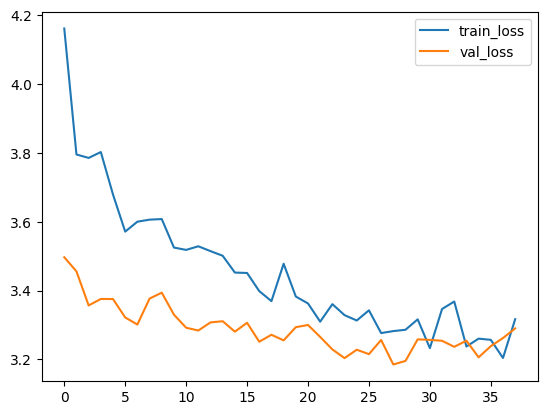

In [15]:
_ = log.plot()

In [16]:
model_tuned.partial_log_likelihood(*val).mean()

np.float32(-5.513582)

In [17]:
_ = model_tuned.compute_baseline_hazards()

In [18]:
surv_tuned = model_tuned.predict_surv_df(x_test)

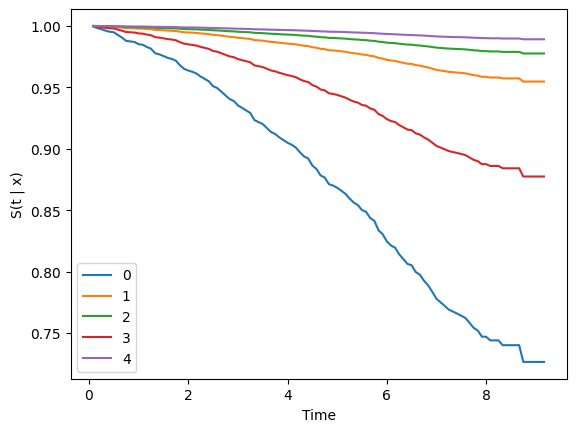

In [19]:
surv_tuned.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
ev_tuned = EvalSurv(surv_tuned, durations_np, events_np, censor_surv='km')

In [21]:
ev_tuned.concordance_td()

0.8083201489064681